# Fitting BKT to students

Criar a seguinte estrutura de dados:
1. ID do aluno
2. ID do problema
3. Lista com soluções 1 a N
6. Lista com conceito mais predominante nas soluções 1 a N
5. Lista indicando se resolveu em 1 a N soluções


### Import libraries

In [8]:
#DB
# from questions.models import UserLog, Problem
from retrieve_model_and_vectorizer import RetrieveModelAndVectorizer
import psycopg2
from spkit import bkt

# Helpers
from sklearn.metrics import roc_curve, auc
import numpy as np
import pickle
import base64
from tqdm.notebook import tqdm
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [133]:
%load_ext autoreload

In [175]:
%autoreload 1

In [176]:
%aimport spkit.bkt

In [177]:
%aimport

Modules to reload:
spkit.bkt

Modules to skip:



### Recreate model and vectorizer

In [2]:
exp_id = 26
vectorizer, model = RetrieveModelAndVectorizer().get_model_and_vectorizer(exp_id)

Problems to be ignored: 656
Problems to be used: 132
Solutions to be used: 54
Got 54 documents


/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.online_lda module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Retrieve users' solutions and practiced skills

In [3]:
def transform(student, model_db, vectorize):
    """ Transform a new observation using the given vectorizer and model """
    train_data_features_student = vectorizer.transform(student).toarray()
    y_student = model_db.transform(train_data_features_student)
    return y_student

def get_skill(student_solution, vectorizer, model_db):
    """ Get argmax topic after transforming a new observation """
    y_student = transform(student_solution, model_db, vectorizer)
    top_skill = np.argmax(y_student, axis=1)
    return top_skill

In [4]:
folder = "data/comp1_2019_2"

In [5]:
%%time
problems = Problem.objects.filter(chapter__isnull=False)
# problems = Problem.objects.filter(chapter__pk=3)
user_blacklist = UserProfile.objects.filter(professor__user__username='sem_professor')
# user_blacklist = ['lmoraes', 'matos.gabriel26@gmail.com', 'angeloacrdaumas@outlook.com', 'giuliaelvira23@poli.ufrj.br',
#                   'hugo', 'gracepassosfreitas@gmail.com', 'carla']
user_blacklist = UserProfile.objects.filter(user__username__in=user_blacklist)
logs_list = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').exclude(user__userprofile__in=user_blacklist).order_by("timestamp")
solution_list = logs_list.values_list('solution', flat=True)
skills = get_skill(solution_list, vectorizer, model)

CPU times: user 29.3 s, sys: 95.9 ms, total: 29.4 s
Wall time: 33.1 s


In [6]:
logs_list.count()

27281

### Put data in proper format

In [7]:
%%time
data = {}
for idx, log in enumerate(tqdm(logs_list)):
    # Data identification is a tuple containing student id and problem id
    student_id = log.user.pk
    problem_id = log.problem.pk
    data_id = (student_id, problem_id)
    
    # If there isn't anything concerning this id, add it to dict
    if not data_id in data.keys():
        data[data_id] = {
            "identifier": "%d-%d" % (student_id, problem_id),
            "student_id": student_id,
            "problem_id": problem_id,
            "solutions": [log.solution],
            "outcomes": [log.outcome],
            "skills": [skills[idx]]
        }
    # If basic information is already there, just complete with solution info
    else:
        data[data_id]["solutions"].append(log.solution)
        data[data_id]["outcomes"].append(log.outcome)
        data[data_id]["skills"].append(skills[idx])

/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 2min 2s, sys: 5.67 s, total: 2min 8s
Wall time: 16min 5s


In [9]:
df = pd.DataFrame(data.values())

In [10]:
df

,identifier,student_id,problem_id,solutions,outcomes,skills
0,378-727,378,727,[# Coloque um comentário dizendo o que a funçã...,[P],[5]
1,393-727,393,727,[# Coloque um comentário dizendo o que a funçã...,"[P, P]","[5, 5]"
2,426-727,426,727,[# Coloque um comentário dizendo o que a funçã...,"[P, P]","[7, 7]"
3,439-727,439,727,[# Coloque um comentário dizendo o que a funçã...,"[F, P, P, F, P, P, P]","[7, 7, 7, 7, 7, 7, 7]"
4,443-727,443,727,[# Coloque um comentário dizendo o que a funçã...,[P],[7]
...,...,...,...,...,...,...
5706,605-769,605,769,[# Coloque um comentário dizendo o que a funçã...,"[F, F, F, F, F, F, F, F, F, F]","[5, 5, 5, 5, 5, 5, 5, 5, 7, 9]"
5707,605-771,605,771,[# Coloque um comentário dizendo o que a funçã...,"[F, F, F, F, F, F, F, F, F, F, P]","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]"
5708,605-772,605,772,[# Coloque um comentário dizendo o que a funçã...,"[F, P]","[5, 5]"
5709,605-773,605,773,[# Coloque um comentário dizendo o que a funçã...,"[F, F]","[7, 7]"


In [17]:
with open("%s/data_2020_02_18_raw_data.pkl" % folder, "wb") as pkl_file:
    pickle.dump(data, pkl_file)

In [18]:
with open("%s/data_2020_02_18_raw_df.pkl" % folder, "wb") as pklfile:
    pickle.dump(df, pklfile)

In [19]:
# Calculate if student learned in the N prediction
def success(row, N):
    if "P" in row["outcomes"][:N]:
        row["solved_in_%d" % N] = 1 # For correct
    else:
        row["solved_in_%d" % N] = 0 # For incorrect
#     skill_str = [str(s) for s in set(row["skills"][:N])]
    row["skill_in_%d" % N] = list(set(row["skills"][:N]))
    return row

In [20]:
%%time
df = df.apply(success, args=(1,), axis=1).apply(success, args=(2,), axis=1).apply(success, args=(3,), axis=1)

CPU times: user 43.9 s, sys: 44.1 ms, total: 44 s
Wall time: 44 s


In [21]:
with open("%s/data_2020_02_18_augmented_df.pkl" % folder, "wb") as pkl_file:
    pickle.dump(df, pkl_file)

In [22]:
df

,identifier,student_id,problem_id,solutions,outcomes,skills,solved_in_1,skill_in_1,solved_in_2,skill_in_2,solved_in_3,skill_in_3
0,378-727,378,727,[# Coloque um comentário dizendo o que a funçã...,[P],[5],1,[5],1,[5],1,[5]
1,393-727,393,727,[# Coloque um comentário dizendo o que a funçã...,"[P, P]","[5, 5]",1,[5],1,[5],1,[5]
2,426-727,426,727,[# Coloque um comentário dizendo o que a funçã...,"[P, P]","[7, 7]",1,[7],1,[7],1,[7]
3,439-727,439,727,[# Coloque um comentário dizendo o que a funçã...,"[F, P, P, F, P, P, P]","[7, 7, 7, 7, 7, 7, 7]",0,[7],1,[7],1,[7]
4,443-727,443,727,[# Coloque um comentário dizendo o que a funçã...,[P],[7],1,[7],1,[7],1,[7]
...,...,...,...,...,...,...,...,...,...,...,...,...
5706,605-769,605,769,[# Coloque um comentário dizendo o que a funçã...,"[F, F, F, F, F, F, F, F, F, F]","[5, 5, 5, 5, 5, 5, 5, 5, 7, 9]",0,[5],0,[5],0,[5]
5707,605-771,605,771,[# Coloque um comentário dizendo o que a funçã...,"[F, F, F, F, F, F, F, F, F, F, P]","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]",0,[5],0,[5],0,[5]
5708,605-772,605,772,[# Coloque um comentário dizendo o que a funçã...,"[F, P]","[5, 5]",0,[5],1,[5],1,[5]
5709,605-773,605,773,[# Coloque um comentário dizendo o que a funçã...,"[F, F]","[7, 7]",0,[7],0,[7],0,[7]


Solved in 1 attempt

In [63]:
%%time
kcs = []
for row in df['skill_in_3'].iteritems():
    kcs.extend(row[1])
kcs = list(set(kcs))
steps = df['identifier'].unique().tolist()

def create_data(row):
    question_id = steps.index(row['identifier'])
    return question_id

df['question_id'] = df.apply(create_data, axis=1)

CPU times: user 550 ms, sys: 51 µs, total: 550 ms
Wall time: 550 ms


In [64]:
%%time
q_matrix = np.zeros((len(steps), len(kcs)))

for idx, item in df.iterrows():
    for kc in item['skill_in_3']:
        kc_col = kcs.index(kc)
        q_matrix[item['question_id'], kc_col] = 1
    
print(q_matrix.shape)

(5711, 8)
CPU times: user 830 ms, sys: 0 ns, total: 830 ms
Wall time: 837 ms


In [48]:
with open('%s/data_2020_02_18_q_matrix.pkl' % folder, 'wb') as pklfile:
    pickle.dump(q_matrix, pklfile)

In [65]:
%%time
# Data matrix
data = df[['solved_in_3', 'student_id', 'question_id']].values.tolist()

# Instantiate model
model = bkt.BKT()
model.fit(data, q_matrix)

CPU times: user 61.9 ms, sys: 11.9 ms, total: 73.8 ms
Wall time: 111 ms


In [66]:
students = df['student_id'].unique().tolist()
len(students)

193

In [51]:
with open('%s/data_2020_02_18_students.pkl' % folder, 'wb') as pklfile:
    pickle.dump(students, pklfile)
with open('%s/data_2020_02_18_model.pkl' % folder, 'wb') as pklfile:
    pickle.dump(model, pklfile)

In [67]:
df.groupby("solved_in_3").count()['student_id']/df.groupby("solved_in_3").count()['student_id'].sum()

solved_in_3
0    0.311854
1    0.688146
Name: student_id, dtype: float64

In [68]:
%%time
data_arr = np.asarray(data)
rmse = 0
n = 0
score_df = []
learning_state = {}
outcome_all = []
predicted_proba = []
for student in students:
    student_idx = np.where(data_arr[:,1] == student)
    outcome = data_arr[student_idx, 0].astype('int64')
    outcome_all += outcome.tolist()[0]
    question_id = data_arr[student_idx, 2].astype('int64')
    data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
    predicted = model.predict_proba(data_student, q_matrix)
    predicted_proba += predicted[:,1].tolist()
    s_ll, s_aic, s_bic, s_rmse, s_acc = model.score()
    fpr, tpr, _ = roc_curve(outcome.flatten(), predicted[:,1], pos_label=1)
    auc_score = auc(fpr, tpr)
    score_df.append({"student": student,
                     "AIC": s_aic,
                     "BIC": s_bic,
                     "RMSE": s_rmse,
                     "Acc": s_acc,
                     "n questions": model.n_questions,
#                      "LL": s_ll,
                     "LL": model.loglikelihood,
                     "correct_outcome": np.where(outcome == 1)[1].shape[0],
                     "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                     "AUC": auc_score})
#     learning_state[student] = model.learning_state

CPU times: user 500 ms, sys: 3.99 ms, total: 504 ms
Wall time: 504 ms


In [69]:
score = pd.DataFrame.from_dict(score_df)

In [54]:
with open('%s/score_chapter_8_2019_10_14.pkl' % folder, 'wb') as pklfile:
    pickle.dump(score, pklfile)
# with open('%s/kdd_2005_2005_learning_state.pkl' % folder, 'wb') as pklfile:
#     pickle.dump(learning_state, pklfile)

In [70]:
rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
rmse_avg = score['RMSE'].mean()
rmse_std = score['RMSE'].std()

In [71]:
print("RMSE de treino: %.2f" % rmse_train)
print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))

RMSE de treino: 0.51
RMSE médio: 0.52 +- 0.07


In [57]:
acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
acc_avg = score['Acc'].mean()
acc_std = score['Acc'].std()

In [72]:
print("Acc de treino: %.2f" % acc_train)
print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))

Acc de treino: 0.52
Acc médio: 0.51 +- 0.21


In [74]:
fpr, tpr, thresholds = roc_curve(outcome_all, predicted_proba, pos_label=1)
auc_score = auc(fpr, tpr)
auc_avg = score['AUC'].mean()
auc_std = score['AUC'].std()

# Sensitivity = tpr = TP/(TP+FN)
# Specificity = 1-fpr = TN/(TN+FP)
# Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
J_stats = tpr - fpr
J_opt_thresholds = thresholds[np.argmax(J_stats)]
print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)

Youden's optimum threshold: 0.62


In [75]:
print("AUC de treino: %.2f" % auc_score)
print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))

AUC de treino: 0.56
AUC médio: 0.48 +- 0.19


In [60]:
estimated_outcome = np.where(np.asarray(predicted_proba) > J_opt_thresholds, 1, 0)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.5431623183330415

In [61]:
# Save threshold
with open('%s/threshold_chapter_8_2019_10_14.pkl' % folder, 'wb') as pklfile:
    pickle.dump(J_opt_thresholds, pklfile)

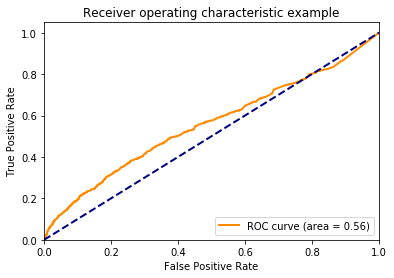

In [76]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [64]:
n_questions = score['n questions'].sum()
p = score['correct_outcome'].sum()/n_questions
# Save p
with open('%s/p_chapter_8_2019_10_14.pkl' % folder, 'wb') as pklfile:
    pickle.dump(p, pklfile)

estimated_outcome = np.random.binomial(1, p, n_questions)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.5017236807212941